In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torchdiffeq import odeint_adjoint as odeint_adjoint
from torchdiffeq import odeint

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Score Model

In [3]:
class ScoreModel():
    def __init__(self, network, grid_size):
        self.network = network
        self.grid_size = grid_size
        
        self.sigma = torch.tensor(25., device=device)
        
    # Diffusion coefficient g(t) at time t
    def diff_coeff(self, t):
        return self.sigma**t
    
    # Standard deviation of p_0t at time t
    def p_0t_standard_deviation(self, t):
        return torch.sqrt( (self.sigma**(2. * t) - 1.) / (2. * torch.log(self.sigma)) )
    
    # Draw samples from the prior distribution
    def draw_init_config(self, n):
        # n: number of samples
        randn = torch.randn(n, self.grid_size, self.grid_size, device=device)
        t = torch.tensor((1.), device=device)
        return randn * self.p_0t_standard_deviation(t)
    
    # Factor of the dt term in the reverse ODE
    def reverse_ode_score_func(self, t, phi):
        t_batch = torch.ones(phi.shape[0], device=device) * t
        self.network.eval()
        with torch.no_grad():
            score = self.network(phi, t_batch)
        sigma_t = self.diff_coeff(t)
        return - sigma_t**2 * score / 2.
    
    # generate samples by solving the ODE
    def solve_ode(self, n, t_end=1e-5):
        init_config = self.draw_init_config(n)
        t_points = torch.linspace(1., t_end, 40, device=device)
        solution = odeint(self.reverse_ode_score_func, init_config, 
                          t_points, options=dict(step_size=1e-2), method = 'rk4')[-1,:]
        return solution
    
    # generate samples by solving the SDE
    def solve_sde(self, n, t_end=1e-5):
        init_config = self.draw_init_config(n)
        dt = 5e-3
        for i in range(int(1./dt)):
            t = 1. - dt*i
            t_batch = torch.ones(init_config.shape[0], device=device) * t
            
            with torch.no_grad():
                score = self.network(init_config, t_batch)
            
            drift_term = - self.diff_coeff(t)**2 * score
            init_config = (init_config + (-1.*dt) * drift_term + 
                     np.sqrt(dt) * self.diff_coeff(t) * torch.randn(init_config.shape, device=device))
        return init_config
    
    # Defining the loss function for given phi_0 sampled from p_0
    def score_loss_function(self, phi_0):
        eps = 1e-5
        t = torch.rand(phi_0.shape[0], device=device) * (1. - eps) + eps #Second part for numerical stability
        lam_sqrt = self.p_0t_standard_deviation(t).view(phi_0.shape[0],1,1)
        std_normal_dist = torch.randn_like(phi_0, device=device)
        phi_t = phi_0 + lam_sqrt * std_normal_dist

        self.network.train()
        score = self.network(phi_t, t)
        loss = torch.sum((std_normal_dist + score * lam_sqrt)**2, dim=(1,2))
        return torch.mean(loss)
    
    # Train the network
    def train_score_loss(self, n_epoch, training_samples, batch_size=6, save_hist_bool=False):
        if save_hist_bool:
            magn_hist = torch.zeros((n_epoch//20,4))
            susc_hist = torch.zeros((n_epoch//20,4))
            binder_hist = torch.zeros((n_epoch//20,4))
        
        n_samples = training_samples.shape[0]

        tqdm_epoch = tqdm.notebook.trange(n_epoch)
        for n in tqdm_epoch:
            self.network.train()
            avg_loss = 0.
            num_items = 0
            rand_perm = torch.randperm(training_samples.shape[0])
            training_samples = training_samples[rand_perm]
            for i in range(n_samples//batch_size):
                training_batch = training_samples[i*batch_size:(i+1)*batch_size].to(device)
                loss = self.score_loss_function(training_batch)
                optimizer.zero_grad()
                loss.backward()    
                optimizer.step()
                avg_loss += loss.item() * batch_size
                num_items += batch_size
            scheduler.step()
            
            if save_hist_bool:
                if n%20==0:
                    generated_samples = self.solve_ode(1000).detach().cpu() * scale_factor
                    magn_hist[n//20,0], magn_hist[n//20,1] = jackknife(generated_samples, magnetization_mean)
                    susc_hist[n//20,0], susc_hist[n//20,1] = jackknife(generated_samples, susceptibility)
                    binder_hist[n//20,0], binder_hist[n//20,1] = jackknife(generated_samples, binder_cumulant)
                    
                    generated_samples = self.solve_sde(1000).detach().cpu() * scale_factor
                    magn_hist[n//20,2], magn_hist[n//20,3] = jackknife(generated_samples, magnetization_mean)
                    susc_hist[n//20,2], susc_hist[n//20,3] = jackknife(generated_samples, susceptibility)
                    binder_hist[n//20,2], binder_hist[n//20,3] = jackknife(generated_samples, binder_cumulant)
                
            tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
            
        if save_hist_bool:
            return magn_hist, susc_hist, binder_hist
    
    
    ################################################################################################
    # Exact likelihood computation
    ################################################################################################
    
    # Multivariate normal distribution
    def log_p_T(self, phi_T):
        prefactor = - self.grid_size**2 / 2. * torch.log(2 * np.pi * self.p_0t_standard_deviation(1.)**2)
        return prefactor - torch.sum(phi_T**2, dim=(1,2)) / (2 * self.p_0t_standard_deviation(1.)**2)
    
    # Argument of the integration part of the likelihood calculator
    def skilling_integrand(self, t, int_t):
        # Input form f(t,x) for the ODE solver, first part of x is the integration, second part is phi_t ODE
        integral_part = int_t[0:self.skilling_batch_size] #irrelevant for calculation
        phi_t = int_t[self.skilling_batch_size:].view(self.skilling_batch_size, self.grid_size, self.grid_size)
        
        phi_t.requires_grad=True
        t_batch = torch.ones(phi_t.shape[0], device=device) * t
        
        self.network.eval()
        score = self.network(phi_t, t_batch)
        
        epsilon_mean = torch.zeros(phi_t.shape[0], device=device)
        
        for i in range(self.skilling_iter):
            epsilon = torch.randn_like(phi_t, device=device)
            grad_score_e = torch.autograd.grad(score, phi_t, grad_outputs = epsilon, create_graph=True)[0]
            eje = grad_score_e * epsilon
            eje = torch.sum(eje, dim=(1,2))
            epsilon_mean += eje.detach()
        div = epsilon_mean / self.skilling_iter
        
        integral_part = (div * self.sigma**(2.*t))
        ode_part = - self.sigma**(2.*t) * score.detach() / 2.
        return torch.cat((integral_part, ode_part.flatten()), dim=0)
    
    # Perform the integration in the likelihood calculator
    def skilling_integrate(self, phi_0):
        integral_steps = 50
        t_int = torch.linspace(1e-5, 1., integral_steps, device=device)
        init_config = torch.cat((torch.zeros(phi_0.shape[0], device=device), phi_0.flatten()), dim=0).detach()

        integral = odeint(self.skilling_integrand, init_config, t_int, method='rk4',options=dict(step_size=1e-2))
        return integral[-1,:]
    
    # Caclculate the likelihood of a given sample
    def log_p_0(self, phi_0, skilling_iter=10):
        self.skilling_iter = skilling_iter
        self.skilling_batch_size = phi_0.shape[0]
        
        int_and_phi = self.skilling_integrate(phi_0)
        integral = int_and_phi[0:phi_0.shape[0]]
        phi_T = int_and_phi[phi_0.shape[0]:].view(phi_0.shape[0], self.grid_size, self.grid_size)
        result = self.log_p_T(phi_T) - integral / 2.
        return result / self.grid_size**2

In [4]:
# Run the independence metropolis
def independence_metropolis(samples, log_p_model, log_p_target):
    accepted_samples = samples[0,None]
    accepted_log_p_model = log_p_model[0,None]
    accepted_log_p_target = log_p_target[0,None]
    
    counter = 0.
    for i in range(1, samples.shape[0]):
        p_accept = torch.exp((accepted_log_p_model[-1] + log_p_target[i]) - (log_p_model[i] + accepted_log_p_target[-1]))
        if torch.rand(1) < p_accept:
            accepted_samples = torch.cat((accepted_samples, samples[i,None]), dim=0)
            accepted_log_p_model = torch.cat((accepted_log_p_model, log_p_model[i,None]), dim=0)
            accepted_log_p_target = torch.cat((accepted_log_p_target, log_p_target[i,None]), dim=0)
            counter += 1.
        else:
            accepted_samples = torch.cat((accepted_samples, samples[i-1,None]), dim=0)
            accepted_log_p_model = torch.cat((accepted_log_p_model, log_p_model[i-1,None]), dim=0)
            accepted_log_p_target = torch.cat((accepted_log_p_target, log_p_target[i-1,None]), dim=0)
    print('Acceptance rate: ', (counter/samples.shape[0]) )        
    return accepted_samples

In [5]:
# Calculate the effective sampling size
def ess(log_p_model, log_p_target):
    log_p_over_q = log_p_target - log_p_model
    term_1 = 2*torch.logsumexp(log_p_over_q, dim=0)
    term_2 = torch.logsumexp(2*log_p_over_q, dim=0)
    return torch.exp(term_1 - term_2) / log_p_model.shape[0]

# Network definition

In [6]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, t):
        t_proj = 2 * np.pi * t[:, None] * self.W[None, :]
        return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

In [7]:
class ScoreNet(nn.Module):
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))
        # n x 1 x 32 x 32 --> n x 32 x 32 x 32:
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        
        # n x 32 x 32 x 32 --> n x 64 x 16 x 16:
        self.conv2 = nn.Conv2d(channels[0], channels[1], 4, stride=2, padding=1, padding_mode='circular', bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        
        # n x 64 x 16 x 16 --> n x 128 x 8 x 8:
        self.conv3 = nn.Conv2d(channels[1], channels[2], 4, stride=2, padding=1, padding_mode='circular', bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        
        # n x 128 x 8 x 8 --> n x 256 x 4 x 4:
        self.conv4 = nn.Conv2d(channels[2], channels[3], 4, stride=2, padding=1, padding_mode='circular', bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        
        
        # n x 256 x 4 x 4 --> n x 128 x 8 x 8:
        self.tconv1 = nn.ConvTranspose2d(channels[3], channels[2], 2, stride=2, bias=False)
        # n x 256 x 8 x 8 --> n x 128 x 8 x 8:
        self.conv5 = nn.Conv2d(channels[3], channels[2], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm1 = nn.GroupNorm(32, num_channels=channels[2])
        
        # n x 128 x 8 x 8 --> n x 64 x 16 x 16:
        self.tconv2 = nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2, bias=False)
        # n x 128 x 16 x 16 --> n x 64 x 16 x 16:
        self.conv6 = nn.Conv2d(channels[2], channels[1], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        
        # n x 64 x 16 x 16 --> n x 32 x 32 x 32:
        self.tconv3 = nn.ConvTranspose2d(channels[1], channels[0], 2, stride=2, bias=False)
        # n x 64 x 32 x 32 --> n x 32 x 32 x 32:
        self.conv7 = nn.Conv2d(channels[1], channels[0], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[0])
        # n x 32 x 32 x 32 --> n x 1 x 32 x 32:
        self.conv8 = nn.Conv2d(channels[0], 1, 3, stride=1, padding=1, padding_mode='circular')

        self.SiLU = torch.nn.SiLU()
        
    def p_0t_standard_deviation(self, t):
        sigma = torch.tensor(25., device=device)
        return torch.sqrt( (sigma**(2. * t) - 1.) / (2. * torch.log(sigma)) )
  
    def forward(self, x, t):
        x = x[:,None,:,:]
        grid_size = x.shape[-1]
        embed = self.SiLU(self.embed(t))
        # Encoding path
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.SiLU(h1)
        
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.SiLU(h2)
        
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.SiLU(h3)
        
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.SiLU(h4)
        
        # Decoding path
        h = self.tconv1(h4)
        h = torch.cat([h, h3], dim=1)###
        h = self.conv5(h)
        h += self.dense5(embed)
        h = self.tgnorm1(h)
        h = self.SiLU(h)
        
        h = self.tconv2(h)
        h = torch.cat([h, h2], dim=1)
        h = self.conv6(h)
        h += self.dense6(embed)
        h = self.tgnorm2(h)
        h = self.SiLU(h)
        
        h = self.tconv3(h)
        h = torch.cat([h, h1], dim=1)
        h = self.conv7(h)
        h += self.dense7(embed)
        h = self.tgnorm3(h)
        h = self.SiLU(h)
        
        h = self.conv8(h)

        # Normalize output
        # Grad log for a normal distribution is input / std_dev,
        # which is implemented here, assuming input=output for the network
        h = h / self.p_0t_standard_deviation(t)[:, None, None, None]
        return h.view(h.shape[0],grid_size,grid_size)

# check results

In [8]:
#plot configs
def plot_samples(samples, img_per_row = 2):
    # Input: - Torch tensor of shape sample-number x channels x dim x dim
    #        - number of samples per row
    samples = samples.cpu().numpy()
    fig, ax = plt.subplots(img_per_row, img_per_row, figsize=(8,8))
    for i in range(img_per_row):
        for j in range(img_per_row):
            ind = i*img_per_row + j
            ax[i,j].imshow(samples[ind], vmin=-0.8, vmax=0.8, cmap='viridis')
            ax[i,j].axes.xaxis.set_visible(False)
            ax[i,j].axes.yaxis.set_visible(False)
    plt.show()

In [9]:
def magnetization(samples):
    grid_size = samples.shape[-1]
    m = torch.sum(samples, dim=(1,2)) / grid_size**2
    return m

In [10]:
def magnetization_mean(samples):
    grid_size = samples.shape[-1]
    m = torch.sum(samples, dim=(1,2)) / grid_size**2
    return torch.mean(m)

In [11]:
def susceptibility(samples):
    grid_size = samples.shape[-1]
    m = magnetization(samples)
    return grid_size**2 * (torch.mean(m**2) - torch.mean(torch.abs(m))**2)

In [12]:
def binder_cumulant(samples):
    m = magnetization(samples)
    return 1. - 1./3. * torch.mean(m**4) / torch.mean(m**2)**2

In [13]:
def jackknife(dataset, observable_fct):
    n = dataset.shape[0]
    expectation_value = observable_fct(dataset)
    
    observables = torch.zeros([n])
    for i in range(n):
        dataset = torch.roll(dataset, -1, 0)
        dataset_i = dataset[:-2]
        observables[i] = observable_fct(dataset_i)
        
    variance = torch.sum((observables - expectation_value)**2) * (n - 1.) / n
    std_dev = torch.sqrt(variance)
    return expectation_value, std_dev

In [14]:
# Parameters
lam = 0.02
grid_size = 32

def action(x, kappa):
    # potential term
    pot = torch.sum((1. - 2. * lam) * x**2 + lam * x**4, dim=(1,2))
    # kinetic term
    dims = range(1, 3)
    kin = 0
    for mu in dims:
        kin += x * torch.roll(x, -1, dims=mu)
    kin = torch.sum(kin, dim=(1,2))
    action = pot - 2. * kappa * kin
    return action / grid_size**2

# Run all until here

# Broken Phase

## Load training data

In [15]:
training_samples_broken = torch.load(r'training_samples_scalar_broken.pt') 
scale_factor_broken = torch.abs(training_samples_broken).max()
scale_factor = scale_factor_broken
print('The normalization factor: ', scale_factor_broken)
training_samples_broken = training_samples_broken / scale_factor_broken

The normalization factor:  tensor(4.9222)


In [16]:
test_samples_broken = torch.load(r'test_samples_scalar_broken.pt') 
test_samples_broken = test_samples_broken / scale_factor_broken

## Training

In [ ]:
net_broken = ScoreNet().to(device)
score_class_broken = ScoreModel(net_broken, grid_size=32)
optimizer = Adam(score_class_broken.network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [ ]:
n_epochs = 1000
score_class_broken.train_score_loss(n_epochs, training_samples_broken, batch_size=128, save_hist_bool=False)

### Training history

In [17]:
net_broken = ScoreNet().to(device)
score_class_broken = ScoreModel(net_broken, grid_size=32)

optimizer = Adam(score_class_broken.network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

n_epochs = 1000
magn_hist, susc_hist, binder_hist = score_class_broken.train_score_loss(n_epochs, training_samples_broken,
                                                                        batch_size=128, save_hist_bool=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
np.savez('training_progress_broken_score.npz', 
         magn_hist=magn_hist.numpy(), susc_hist = susc_hist.numpy(), binder_hist=binder_hist.numpy(), x_axis=x_axis)

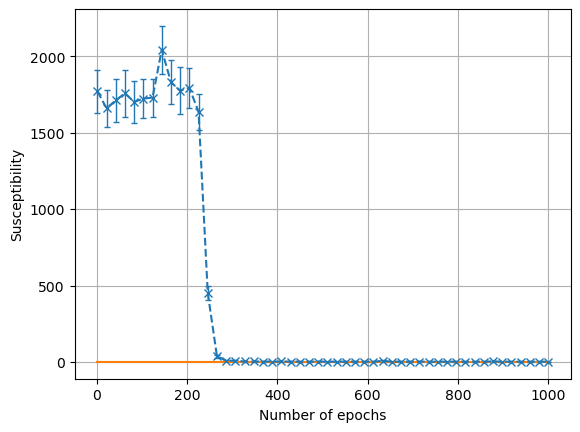

In [18]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis, susc_hist[:,2].numpy(), yerr=susc_hist[:,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis, np.ones(n_epochs//20)*susceptibility(training_samples_broken*scale_factor_broken).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Susceptibility')
#plt.legend()
plt.grid()
plt.show()

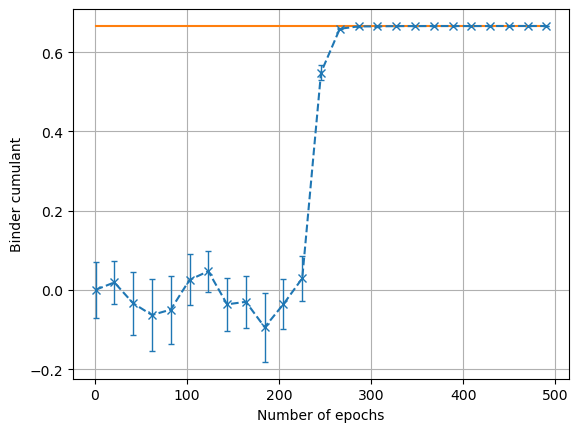

In [19]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis[0:25], binder_hist[0:25,2].numpy(), yerr=binder_hist[0:25,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis[:25], np.ones(n_epochs//20)[:25]*binder_cumulant(training_samples_broken*scale_factor_broken).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Binder cumulant')
#plt.legend()
plt.grid()
plt.show()

#### Comparison between ODE and SDE

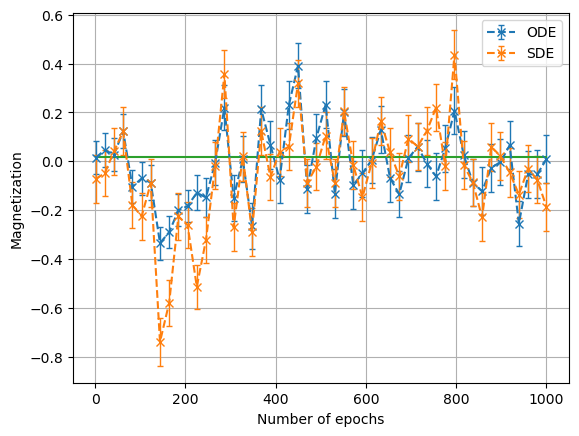

In [20]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis, magn_hist[:,0].numpy(), yerr=magn_hist[:,1].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='ODE')
plt.errorbar(x_axis, magn_hist[:,2].numpy(), yerr=magn_hist[:,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis, np.ones(n_epochs//20)*magnetization_mean(training_samples_broken*scale_factor_broken).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Magnetization')
plt.legend()
plt.grid()
plt.show()

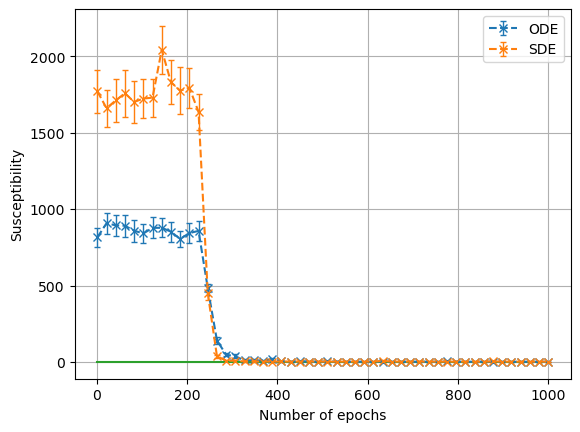

In [21]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis[0:], susc_hist[0:,0].numpy(), yerr=susc_hist[0:,1].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='ODE')
plt.errorbar(x_axis[0:], susc_hist[0:,2].numpy(), yerr=susc_hist[0:,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis, np.ones(n_epochs//20)*susceptibility(training_samples_broken*scale_factor_broken).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid()
plt.show()

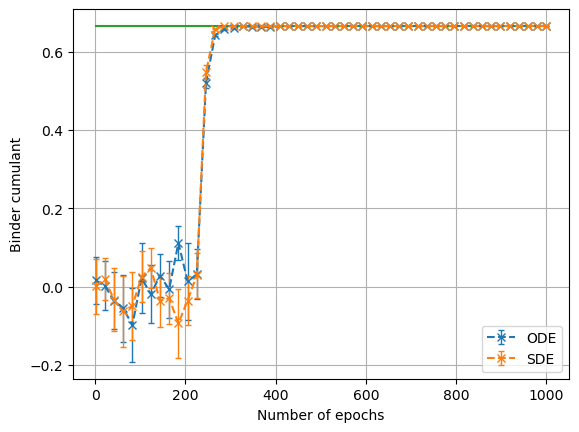

In [22]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis[0:], binder_hist[0:,0].numpy(), yerr=binder_hist[0:,1].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='ODE')
plt.errorbar(x_axis[0:], binder_hist[0:,2].numpy(), yerr=binder_hist[0:,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis, np.ones(n_epochs//20)*binder_cumulant(training_samples_broken*scale_factor_broken).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Binder cumulant')
plt.legend()
plt.grid()
plt.show()

## Results

In [23]:
generated_samples_broken = score_class_broken.solve_sde(1000).detach().cpu()

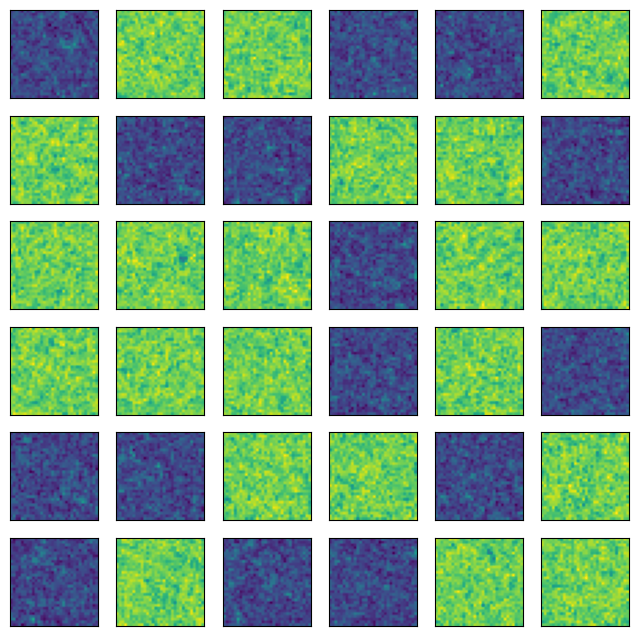

In [24]:
# Test samples
index = torch.randperm(training_samples_broken.shape[0])
plot_samples(training_samples_broken[index], img_per_row=6)

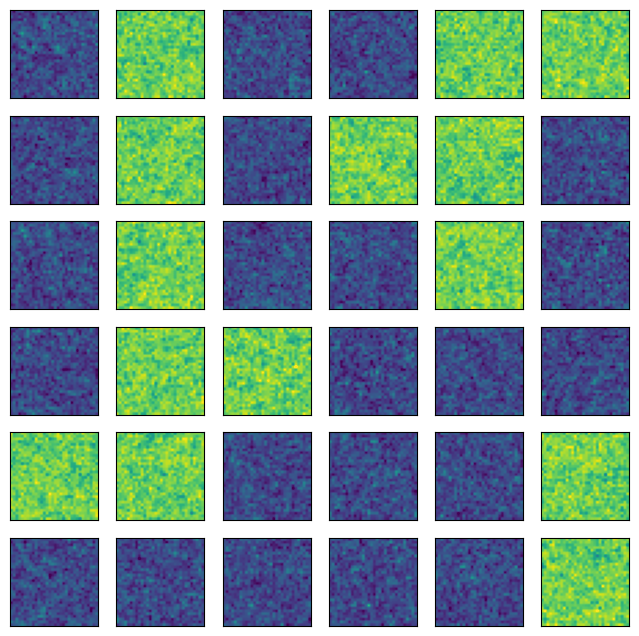

In [25]:
# Generated samples
plot_samples(generated_samples_broken, img_per_row=6)

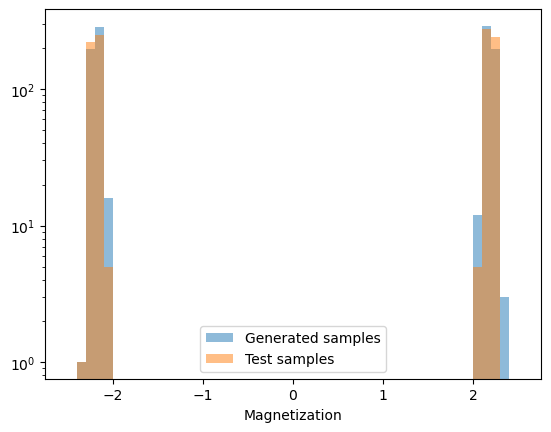

In [26]:
plt.hist(magnetization(generated_samples_broken * scale_factor_broken), bins=50, alpha=0.5,
         label='Generated samples', range=(-2.5,2.5))
plt.hist(magnetization(test_samples_broken * scale_factor_broken), bins=50, alpha=0.5, 
         label='Test samples', range=(-2.5,2.5))
plt.xlabel('Magnetization')
plt.legend()
plt.semilogy()
plt.show()

In [27]:
mean, var = jackknife(test_samples_broken*scale_factor_broken, magnetization_mean)
print('Magnetization of test samples: ', mean, ' +- ', var)

mean, var = jackknife(generated_samples_broken*scale_factor_broken, magnetization_mean)
print('Magnetization of generated samples: ', mean, ' +- ', var)

Magnetization of test samples:  tensor(0.0972)  +-  tensor(0.0977)
Magnetization of generated samples:  tensor(0.0090)  +-  tensor(0.0973)


In [28]:
mean, var = jackknife(test_samples_broken*scale_factor_broken, susceptibility)
print('Susceptibility of test samples: ', mean, ' +- ', var)

mean, var = jackknife(generated_samples_broken*scale_factor_broken, susceptibility)
print('Susceptibility of generated samples: ', mean, ' +- ', var)

Susceptibility of test samples:  tensor(1.5962)  +-  tensor(0.0998)
Susceptibility of generated samples:  tensor(1.8379)  +-  tensor(0.1314)


In [29]:
mean, var = jackknife(test_samples_broken*scale_factor_broken, binder_cumulant)
print('Binder cumulant of test samples: ', mean, ' +- ', var)

mean, var = jackknife(generated_samples_broken*scale_factor_broken, binder_cumulant)
print('Binder cumulant of generated samples: ', mean, ' +- ', var)

Binder cumulant of test samples:  tensor(0.6662)  +-  tensor(2.6240e-05)
Binder cumulant of generated samples:  tensor(0.6662)  +-  tensor(3.5407e-05)


## Metropolis algorithm

In [30]:
log_p_0_list_broken = score_class_broken.log_p_0(generated_samples_broken[0:250].to(device), 
                                   skilling_iter=15)

for i in range(1,4):
    print(i)
    log_p_0_list_broken = torch.cat((log_p_0_list_broken, score_class_broken.log_p_0(
        generated_samples_broken[i*250:(i+1)*250].to(device), 
        skilling_iter=15)))

1
2
3


In [31]:
neg_action = - action(generated_samples_broken*scale_factor_broken, kappa = 0.3)

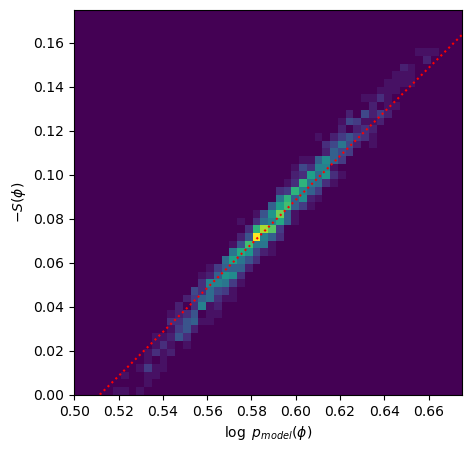

In [32]:
S = -neg_action.numpy()
S_eff = -log_p_0_list_broken.cpu().numpy()
fit_b = np.mean(-S) - np.mean(-S_eff)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist2d(log_p_0_list_broken.cpu().numpy(), neg_action.numpy(), bins=50, range=((0.5,0.675),(0.0,0.175)))
ax.set_xlabel(r'$\log~p_{model}(\phi)$')
ax.set_ylabel(r'$-S(\phi)$')
xs = np.linspace(-35, 35, num=10)
ax.plot(xs, xs + fit_b, ':', color='r', label='slope 1 fit')
plt.show()

In [33]:
ess(log_p_0_list_broken.cpu(), neg_action).item()

0.9999691247940063

In [34]:
metropolis_samples = independence_metropolis(generated_samples_broken, 
                                                                        log_p_0_list_broken.cpu(), neg_action)

Acceptance rate:  0.996


Samples given by the Metropolis algorithm:

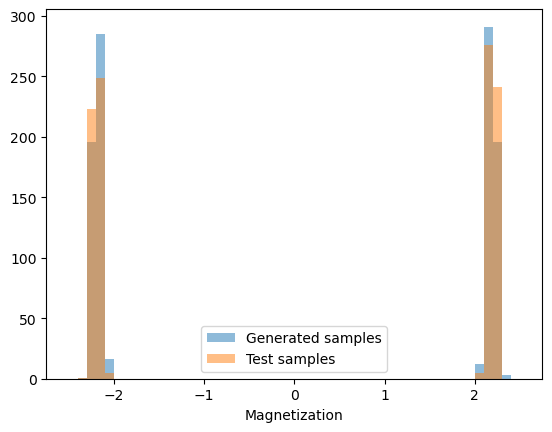

In [42]:
plt.hist(magnetization(metropolis_samples * scale_factor_broken), bins=50, alpha=0.5,
         label='Generated samples', range=(-2.5,2.5))
plt.hist(magnetization(test_samples_broken[0:metropolis_samples.shape[0]] * scale_factor_broken), bins=50, alpha=0.5, 
         label='Test samples', range=(-2.5,2.5))
plt.xlabel('Magnetization')
plt.legend()
plt.show()

Magnetization

In [36]:
mean, var = jackknife(training_samples_broken*scale_factor_broken, magnetization_mean)
print('Magnetization of training samples: ', mean, ' +- ', var)

print('Magnetization of test samples: ', 
      jackknife(test_samples_broken*scale_factor_broken, magnetization_mean)[0], 
     ' +- ', jackknife(test_samples_broken*scale_factor_broken, magnetization_mean)[1])

Magnetization of training samples:  tensor(0.0156)  +-  tensor(0.0309)
Magnetization of test samples:  tensor(0.0972)  +-  tensor(0.0977)


In [37]:
print('Magnetization of generated samples: ', 
      jackknife(generated_samples_broken*scale_factor_broken, magnetization_mean)[0], 
     ' +- ', jackknife(generated_samples_broken*scale_factor_broken, magnetization_mean)[1])

print('Magnetization of Metropolis samples: ', 
      jackknife(metropolis_samples*scale_factor_broken, magnetization_mean)[0], 
     ' +- ', jackknife(metropolis_samples*scale_factor_broken, magnetization_mean)[1])

Magnetization of generated samples:  tensor(0.0090)  +-  tensor(0.0973)
Magnetization of Metropolis samples:  tensor(0.0090)  +-  tensor(0.0973)


Susceptibility

In [38]:
mean, var = jackknife(training_samples_broken*scale_factor_broken, susceptibility)
print('Susceptibility of training samples: ', mean, ' +- ', var)

print('Susceptibility of test samples: ', 
      jackknife(test_samples_broken*scale_factor_broken, susceptibility)[0], 
     ' +- ', jackknife(test_samples_broken*scale_factor_broken, susceptibility)[1])

Susceptibility of training samples:  tensor(1.5430)  +-  tensor(0.0852)
Susceptibility of test samples:  tensor(1.5962)  +-  tensor(0.0998)


In [39]:
print('Susceptibility of generated samples: ', 
      jackknife(generated_samples_broken*scale_factor_broken, susceptibility)[0], 
     ' +- ', jackknife(generated_samples_broken*scale_factor_broken, susceptibility)[1])

print('Susceptibility of Metropolis samples: ', 
      jackknife(metropolis_samples*scale_factor_broken, susceptibility)[0], 
     ' +- ', jackknife(metropolis_samples*scale_factor_broken, susceptibility)[1])

Susceptibility of generated samples:  tensor(1.8379)  +-  tensor(0.1314)
Susceptibility of Metropolis samples:  tensor(1.8335)  +-  tensor(0.1313)


Binder cumulant

In [40]:
mean, var = jackknife(training_samples_broken*scale_factor_broken, binder_cumulant)
print('Binder cumulant of training samples: ', mean, ' +- ', var)

print('Binder cumulant of test samples: ', 
      jackknife(test_samples_broken*scale_factor_broken, binder_cumulant)[0], 
     ' +- ', jackknife(test_samples_broken*scale_factor_broken, binder_cumulant)[1])

Binder cumulant of training samples:  tensor(0.6663)  +-  tensor(9.7479e-06)
Binder cumulant of test samples:  tensor(0.6662)  +-  tensor(2.6240e-05)


In [41]:
print('Binder cumulant of generated samples: ', 
      jackknife(generated_samples_broken*scale_factor_broken, binder_cumulant)[0], 
     ' +- ', jackknife(generated_samples_broken*scale_factor_broken, binder_cumulant)[1])

print('Binder cumulant of Metropolis samples: ', 
      jackknife(metropolis_samples*scale_factor_broken, binder_cumulant)[0], 
     ' +- ', jackknife(metropolis_samples*scale_factor_broken, binder_cumulant)[1])

Binder cumulant of generated samples:  tensor(0.6662)  +-  tensor(3.5407e-05)
Binder cumulant of Metropolis samples:  tensor(0.6662)  +-  tensor(3.5438e-05)


# Symmetric phase

## Load training data

In [15]:
training_samples_sym = torch.load(r'training_samples_scalar_symmetric.pt') 
scale_factor_sym = torch.abs(training_samples_sym).max()
scale_factor = scale_factor_sym
print('The normalization factor: ', scale_factor_sym)
training_samples_sym = training_samples_sym / scale_factor_sym

The normalization factor:  tensor(3.6811)


In [16]:
test_samples_sym = torch.load(r'test_samples_scalar_symmetric.pt') 
test_samples_sym = test_samples_sym/ scale_factor_sym

## Training

In [ ]:
net_sym = ScoreNet().to(device)
score_class_sym = ScoreModel(net_sym, grid_size=32)

optimizer = Adam(score_class_sym.network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [ ]:
score_class_sym.train_score_loss(1000, training_samples_sym, batch_size=200)

### Training history

In [18]:
net_sym = ScoreNet().to(device)
score_class_sym = ScoreModel(net_sym, grid_size=32)

optimizer = Adam(score_class_sym.network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

n_epochs = 500
magn_hist, susc_hist, binder_hist = score_class_sym.train_score_loss(n_epochs, training_samples_sym,
                                                                        batch_size=200, save_hist_bool=True)

  0%|          | 0/500 [00:00<?, ?it/s]

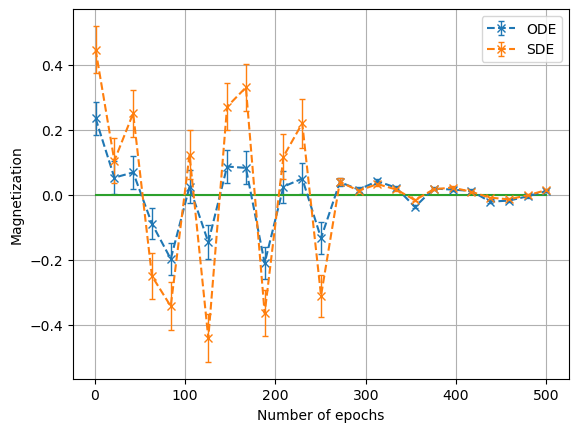

In [19]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis, magn_hist[:,0].numpy(), yerr=magn_hist[:,1].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='ODE')
plt.errorbar(x_axis, magn_hist[:,2].numpy(), yerr=magn_hist[:,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis, np.ones(n_epochs//20)*magnetization_mean(training_samples_sym*scale_factor_sym).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Magnetization')
plt.legend()
plt.grid()
plt.show()

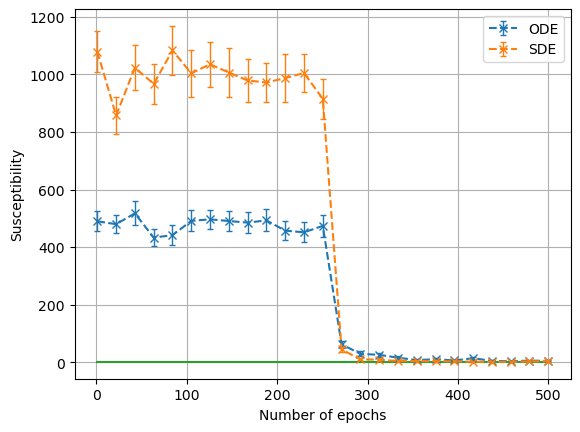

In [20]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis[0:], susc_hist[0:,0].numpy(), yerr=susc_hist[0:,1].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='ODE')
plt.errorbar(x_axis[0:], susc_hist[0:,2].numpy(), yerr=susc_hist[0:,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis, np.ones(n_epochs//20)*susceptibility(training_samples_sym*scale_factor_sym).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid()
plt.show()

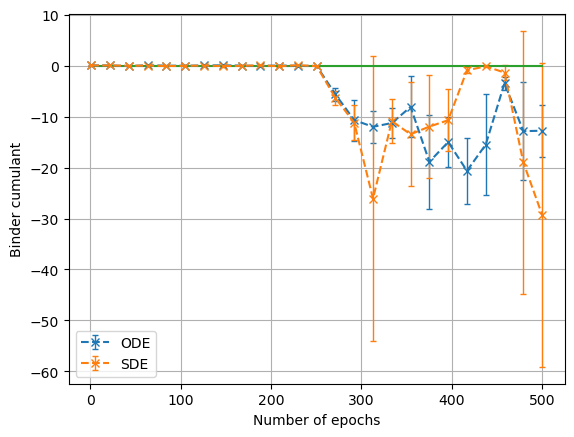

In [21]:
x_axis = np.linspace(1,n_epochs,n_epochs//20)
plt.errorbar(x_axis[0:], binder_hist[0:,0].numpy(), yerr=binder_hist[0:,1].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='ODE')
plt.errorbar(x_axis[0:], binder_hist[0:,2].numpy(), yerr=binder_hist[0:,3].numpy(), 
             fmt='x--', elinewidth=1, capsize=2, label='SDE')
plt.plot(x_axis, np.ones(n_epochs//20)*binder_cumulant(training_samples_sym*scale_factor_sym).cpu().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('Binder cumulant')
plt.legend()
plt.grid()
plt.show()

## results

In [22]:
generated_samples_sym = score_class_sym.solve_sde(1000).detach().cpu()

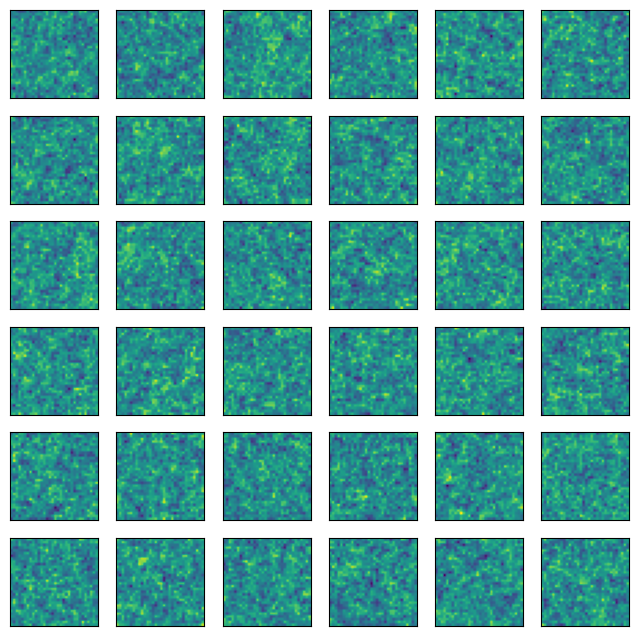

In [23]:
# Test samples
index = torch.randperm(test_samples_sym.shape[0])
plot_samples(test_samples_sym[index], img_per_row=6)

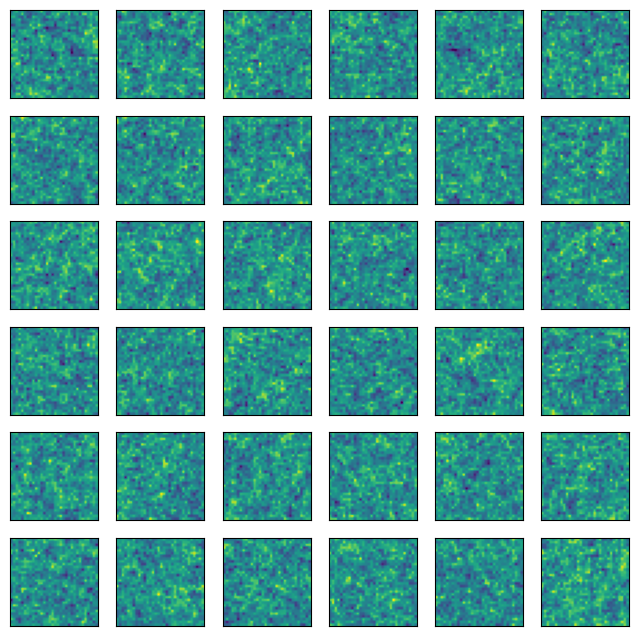

In [24]:
# Generated samples
plot_samples(generated_samples_sym, img_per_row=6)

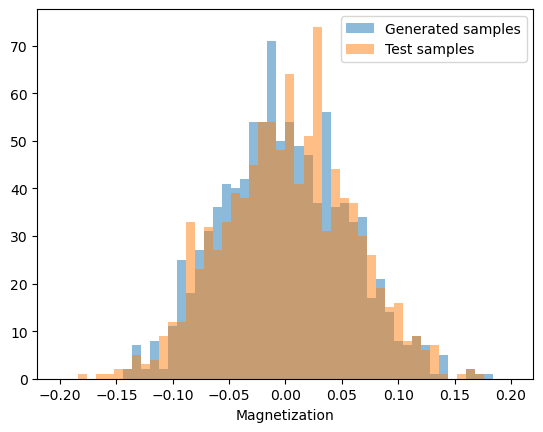

In [25]:
plt.hist(magnetization(generated_samples_sym * scale_factor_sym), bins=50, alpha=0.5,
         label='Generated samples', range=(-0.2,0.2))
plt.hist(magnetization(test_samples_sym * scale_factor_sym), bins=50, alpha=0.5, 
         label='Test samples', range=(-0.2,0.2))
plt.xlabel('Magnetization')
plt.legend()
plt.show()

In [26]:
print('Magnetization of test samples: ', 
      jackknife(test_samples_sym*scale_factor_sym, magnetization_mean)[0], 
     ' +- ', jackknife(test_samples_sym*scale_factor_sym, magnetization_mean)[1])

print('Magnetization of generated samples: ', 
      jackknife(generated_samples_sym*scale_factor_sym, magnetization_mean)[0], 
     ' +- ', jackknife(generated_samples_sym*scale_factor_sym, magnetization_mean)[1])

Magnetization of test samples:  tensor(0.0017)  +-  tensor(0.0026)
Magnetization of generated samples:  tensor(-9.0726e-05)  +-  tensor(0.0026)


In [27]:
print('Susceptibility of test samples: ', 
      jackknife(test_samples_sym*scale_factor_sym, susceptibility)[0], 
     ' +- ', jackknife(test_samples_sym*scale_factor_sym, susceptibility)[1])

print('Susceptibility of generated samples: ', 
      jackknife(generated_samples_sym*scale_factor_sym, susceptibility)[0], 
     ' +- ', jackknife(generated_samples_sym*scale_factor_sym, susceptibility)[1])

Susceptibility of test samples:  tensor(1.2020)  +-  tensor(0.0875)
Susceptibility of generated samples:  tensor(1.2037)  +-  tensor(0.1151)


In [28]:
print('Binder cumulant of test samples: ', 
      jackknife(test_samples_sym*scale_factor_sym, binder_cumulant)[0], 
     ' +- ', jackknife(test_samples_sym*scale_factor_sym, binder_cumulant)[1])

print('Binder cumulant of generated samples: ', 
      jackknife(generated_samples_sym*scale_factor_sym, binder_cumulant)[0], 
     ' +- ', jackknife(generated_samples_sym*scale_factor_sym, binder_cumulant)[1])

Binder cumulant of test samples:  tensor(0.0469)  +-  tensor(0.0683)
Binder cumulant of generated samples:  tensor(-0.1145)  +-  tensor(0.1853)


## Metropolis algorithm

In [29]:
log_p_0_list_sym = score_class_sym.log_p_0(generated_samples_sym[0:250].to(device), skilling_iter=15)

for i in range(1,4):
    print(i)
    log_p_0_list_sym = torch.cat((log_p_0_list_sym, score_class_sym.log_p_0(
        generated_samples_sym[i*250:(i+1)*250].to(device), skilling_iter=15)))

1
2
3


In [30]:
neg_action = - action(generated_samples_sym*scale_factor_sym, kappa = 0.22)

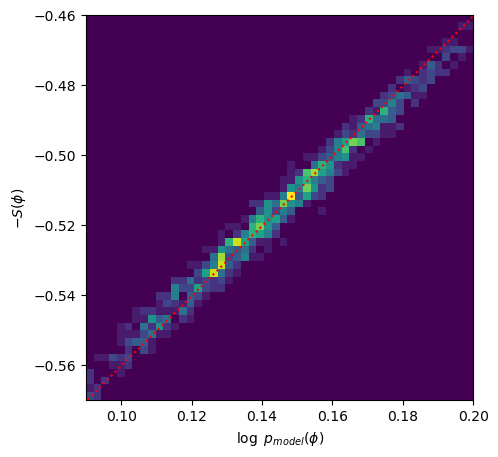

In [31]:
S = -neg_action.numpy()
S_eff = -log_p_0_list_sym.cpu().numpy()
fit_b = np.mean(-S) - np.mean(-S_eff)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist2d(log_p_0_list_sym.cpu().numpy(), neg_action.numpy(), bins=50, range=((0.09,0.2),(-0.57,-0.46)))
ax.set_xlabel(r'$\log~p_{model}(\phi)$')
ax.set_ylabel(r'$-S(\phi)$')
xs = np.linspace(-35, 35, num=10)
ax.plot(xs, xs + fit_b, ':', color='r', label='slope 1 fit')
plt.show()

In [32]:
metropolis_samples = independence_metropolis(generated_samples_sym, log_p_0_list_sym.cpu(), neg_action)

Acceptance rate:  0.997


In [33]:
ess(log_p_0_list_sym.cpu(), neg_action).item()

0.9999862909317017

Magnetization

In [34]:
print('Magnetization of training samples: ', 
      jackknife(training_samples_sym*scale_factor_sym, magnetization_mean)[0], 
     ' +- ', jackknife(training_samples_sym*scale_factor_sym, magnetization_mean)[1])

print('Magnetization of test samples: ', 
      jackknife(test_samples_sym*scale_factor_sym, magnetization_mean)[0], 
     ' +- ', jackknife(test_samples_sym*scale_factor_sym, magnetization_mean)[1])

Magnetization of training samples:  tensor(3.4857e-05)  +-  tensor(0.0008)
Magnetization of test samples:  tensor(0.0017)  +-  tensor(0.0026)


In [35]:
print('Magnetization of generated samples: ', 
      jackknife(generated_samples_sym*scale_factor_sym, magnetization_mean)[0], 
     ' +- ', jackknife(generated_samples_sym*scale_factor_sym, magnetization_mean)[1])

print('Magnetization of Metropolis samples: ', 
      jackknife(metropolis_samples*scale_factor_sym, magnetization_mean)[0], 
     ' +- ', jackknife(metropolis_samples*scale_factor_sym, magnetization_mean)[1])

Magnetization of generated samples:  tensor(-9.0726e-05)  +-  tensor(0.0026)
Magnetization of Metropolis samples:  tensor(-6.5463e-06)  +-  tensor(0.0026)


Susceptibility

In [36]:
print('Susceptibility of training samples: ', 
      jackknife(training_samples_sym*scale_factor_sym, susceptibility)[0], 
     ' +- ', jackknife(training_samples_sym*scale_factor_sym, susceptibility)[1])

print('Susceptibility of test samples: ', 
      jackknife(test_samples_sym*scale_factor_sym, susceptibility)[0], 
     ' +- ', jackknife(test_samples_sym*scale_factor_sym, susceptibility)[1])

Susceptibility of training samples:  tensor(1.1656)  +-  tensor(0.0286)
Susceptibility of test samples:  tensor(1.2020)  +-  tensor(0.0875)


In [37]:
print('Susceptibility of generated samples: ', 
      jackknife(generated_samples_sym*scale_factor_sym, susceptibility)[0], 
     ' +- ', jackknife(generated_samples_sym*scale_factor_sym, susceptibility)[1])

print('Susceptibility of Metropolis samples: ', 
      jackknife(metropolis_samples*scale_factor_sym, susceptibility)[0], 
     ' +- ', jackknife(metropolis_samples*scale_factor_sym, susceptibility)[1])

Susceptibility of generated samples:  tensor(1.2037)  +-  tensor(0.1151)
Susceptibility of Metropolis samples:  tensor(1.2042)  +-  tensor(0.1152)


Binder cumulant

In [38]:
print('Binder cumulant of training samples: ', 
      jackknife(training_samples_sym*scale_factor_sym, binder_cumulant)[0], 
     ' +- ', jackknife(training_samples_sym*scale_factor_sym, binder_cumulant)[1])

print('Binder cumulant of test samples: ', 
      jackknife(test_samples_sym*scale_factor_sym, binder_cumulant)[0], 
     ' +- ', jackknife(test_samples_sym*scale_factor_sym, binder_cumulant)[1])

Binder cumulant of training samples:  tensor(-0.0142)  +-  tensor(0.0223)
Binder cumulant of test samples:  tensor(0.0469)  +-  tensor(0.0683)


In [39]:
print('Binder cumulant of generated samples: ', 
      jackknife(generated_samples_sym*scale_factor_sym, binder_cumulant)[0], 
     ' +- ', jackknife(generated_samples_sym*scale_factor_sym, binder_cumulant)[1])

print('Binder cumulant of Metropolis samples: ', 
      jackknife(metropolis_samples*scale_factor_sym, binder_cumulant)[0], 
     ' +- ', jackknife(metropolis_samples*scale_factor_sym, binder_cumulant)[1])

Binder cumulant of generated samples:  tensor(-0.1145)  +-  tensor(0.1853)
Binder cumulant of Metropolis samples:  tensor(-0.1166)  +-  tensor(0.1858)
